### Project Overview

This project utilizes Yellow Cab data, provided by the  NYC Taxi and Limousine Commission, to predict three different parameters:

1. Total  Fare prediction - Fare + Tips 
2. Elapsed time (ride duration) prediction 
3. "Trip combination" traffic volume 

The data can be found at https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page, with the Yellow Cab data dictionary available at https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf.



In [ ]:
# Import packages
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

In [ ]:
# Read data
file = "yellow_tripdata_2022-03.parquet"
df = spark.read.parquet(file, header = True, inferSchema = True)

In [ ]:
df.createOrReplaceTempView("df")

#### Exploratory Data Analysis

In [ ]:
# Print df schema
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [ ]:
# Examine first 5 rows of data
# Breaking the dataframe into chunks for display purposes
first_list = ["VendorID","tpep_pickup_datetime","tpep_dropoff_datetime","passenger_count","trip_distance"]
second_list = ["RatecodeID","store_and_fwd_flag","PULocationID","DOLocationID","payment_type"]
third_list = ["fare_amount","extra","mta_tax","tip_amount","tolls_amount"]
fourth_list = ["improvement_surcharge","total_amount","congestion_surcharge","airport_fee"]
lists = [first_list, second_list, third_list, fourth_list]

for element in lists: 
    df.select(element).show(5)

+--------+--------------------+---------------------+---------------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|
+--------+--------------------+---------------------+---------------+-------------+
|       1| 2022-02-28 19:13:08|  2022-02-28 19:24:35|            1.0|          2.4|
|       1| 2022-02-28 19:47:52|  2022-02-28 20:00:08|            1.0|          2.2|
|       2| 2022-02-28 19:02:46|  2022-02-28 19:46:43|            1.0|        19.78|
|       2| 2022-02-28 19:52:43|  2022-02-28 20:03:40|            2.0|         2.94|
|       2| 2022-02-28 19:15:35|  2022-02-28 19:34:13|            1.0|         8.57|
+--------+--------------------+---------------------+---------------+-------------+
only showing top 5 rows

+----------+------------------+------------+------------+------------+
|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|
+----------+------------------+------------+------------+------------+
|     

In [ ]:
# Find dimensions of data
original_length = df.count()
print("Dimensions of original dataframe is:")
print(original_length, len(df.columns))

Dimensions of original dataframe is:
3627882 19


In [ ]:
# Drop missing values from dataframe
df = df.na.drop()

In [ ]:
# Drop  duplicates from dataframe
df = df.dropDuplicates()

In [ ]:
# Find dimensions of data after dropping missing values and duplicates (take moderate time to run)
cleaned_length = df.count()
print("Dimensions of dataframe is now:")
print(cleaned_length, len(df.columns))

Dimensions of dataframe is now:
3510068 19


In [ ]:
# Remaining data in the dataframe
remaining_data_perc = cleaned_length/original_length*100
print("We have retained "+str(remaining_data_perc)+" of the data after eliminating null values and duplicates.")

We have retained 96.75254046300293 of the data after eliminating null values and duplicates.


### Data Visualization

In [ ]:
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import warnings; warnings.simplefilter('ignore')

In [ ]:
# Due to size of PySpark dataframe a sample will be taken which statistically will represent overall data
pandas_df = df.sample(False, 0.1, seed=42).toPandas()

In [ ]:
Passenger_count=pandas_df['passenger_count'].value_counts()

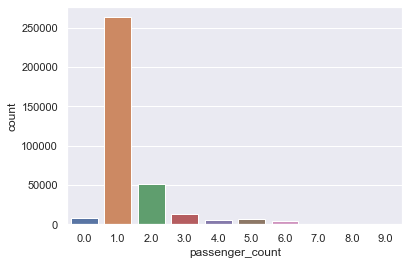

In [ ]:
sns.countplot(x='passenger_count',data=pandas_df)

In [ ]:
pip install -U seaborn

Requirement already up-to-date: seaborn in c:\users\sumid\anaconda3\lib\site-packages (0.12.2)
Note: you may need to restart the kernel to use updated packages.


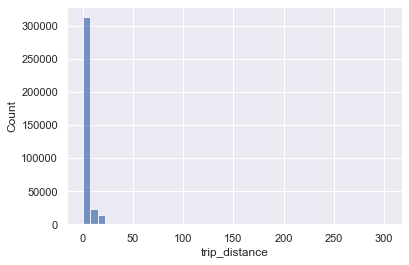

In [ ]:
sns.histplot(pandas_df['trip_distance'],kde=False,bins=40);

In [ ]:
pandas_df['payment_type'].value_counts()

1    278968
2     69330
3      1586
4      1518
Name: payment_type, dtype: int64

In [ ]:
total_amount_by_type = pandas_df.groupby('payment_type')['total_amount'].sum()

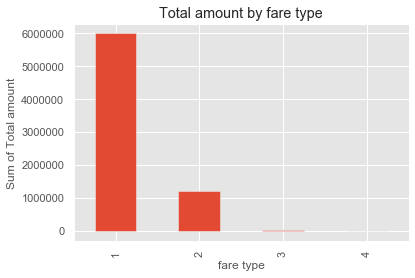

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
total_amount_by_type.plot(kind='bar');
plt.ylabel('Sum of Total amount');
plt.xlabel('fare type');
plt.title('Total amount by fare type');

In [ ]:
pandas_df['pickup_day']=pandas_df['tpep_pickup_datetime'].dt.day_name()
pandas_df['dropoff_day']=pandas_df['tpep_dropoff_datetime'].dt.day_name()
pandas_df['pickup_day_no']=pandas_df['tpep_pickup_datetime'].dt.weekday
pandas_df['dropoff_day_no']=pandas_df['tpep_dropoff_datetime'].dt.weekday
pandas_df['pickup_hour']=pandas_df['tpep_pickup_datetime'].dt.hour
pandas_df['dropoff_hour']=pandas_df['tpep_dropoff_datetime'].dt.hour

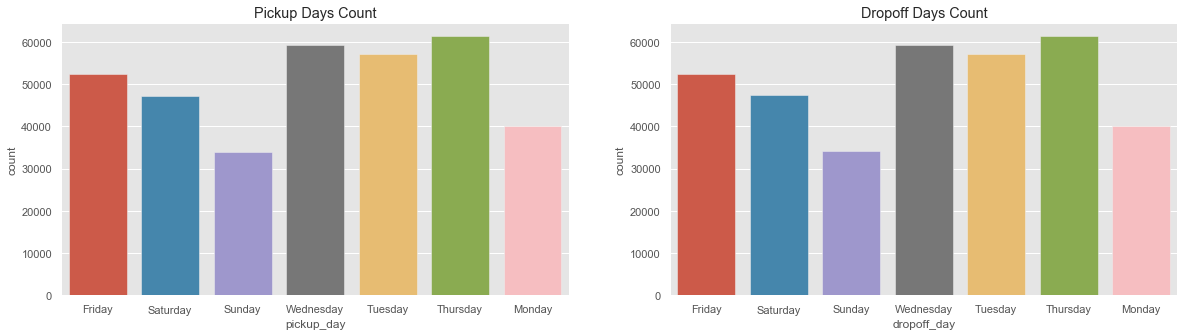

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days Count')
ax=sns.countplot(x="pickup_day",data=pandas_df,ax=ax1)
ax2.set_title('Dropoff Days Count')
ax=sns.countplot(x="dropoff_day",data=pandas_df,ax=ax2)

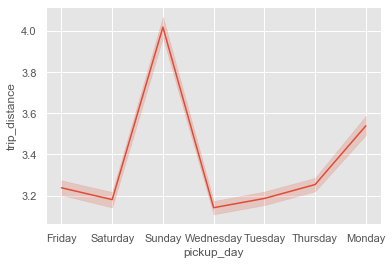

In [ ]:
sns.lineplot(x='pickup_day',y='trip_distance',data=pandas_df);

#### Feature Engineering

In [ ]:
# Create new feature reflecting elapsed trip times (in seconds)
df = df.withColumn("elapsed_time", (df["tpep_dropoff_datetime"].cast("long")-df["tpep_pickup_datetime"].cast("long")))

# Create column indicating the day of week of the pickup
df = df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

# Create column indicating the hour of the pickup
df = df.withColumn("hour", F.hour("tpep_pickup_datetime"))

In [ ]:
# Filter out any rows where tpep_dropoff_datetime is less than tpep_pickup_datetime and trips are < 3 hrs (10,800 seconds)
df = df.where((df.tpep_dropoff_datetime > df.tpep_pickup_datetime) & (df.elapsed_time < 10800))

In [ ]:
# Columns to drop from PySpark dataframe and pandas dataframe
# Drop Store_and_fwd_flag: only provides information as to type of memory to store the trip data (in vehicle or server)
# Drop all fare/cost data other than total_amount to avoid information leakeage as this data is not known prior to the trip
# Drop tpep_dropoff_datetime as we have pickup time and elapsed time
drop_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag", "payment_type", "fare_amount", "extra",
             "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"]

In [ ]:
# Drop dropCols from PySpark dataframe
df = df.drop(*drop_cols)

In [ ]:
# Create new column trip combining tuple combinations of PULocationID and DOLocationID
df = df.withColumn("trip", F.concat(F.col("PULocationID"), F.lit("_"), F.col("DOLocationID")))

In [ ]:
# Fore One-Hot_Encoding we will need to reduce the number of trip categories to manage the size of the dataframe
# Filter dataframe for trip frequencies > threshold
trip_freq_threshold = 8000
mask = df.groupBy("trip").count().where(F.col("count") > trip_freq_threshold)
print("Number of trips > " +str(trip_freq_threshold)+ " is: " + str(mask.count()))
filtered_trips = [data[0] for data in mask.select('trip').collect()]
filtered_trips

Number of trips > 8000 is: 13


['236_236',
 '237_237',
 '237_236',
 '141_236',
 '236_237',
 '237_161',
 '264_264',
 '161_236',
 '161_237',
 '239_142',
 '239_238',
 '236_161',
 '142_239']

In [ ]:
# Filter df for values only in filtered_trips list
df = df.where(df.trip.isin(filtered_trips))

#### More feature engineering to prepare for machine learning

In [ ]:
# Convert trip from type string to numeric
from pyspark.ml.feature import StringIndexer
string_cols = ["trip"]
idx_cols = ["trip_idx"]
stringIndexer = StringIndexer(inputCols=string_cols, outputCols=idx_cols)
 
# Fit transformer
model = stringIndexer.fit(df)
 
# Apply transformer
df = model.transform(df).drop(*string_cols)

In [ ]:
# One-Hot_Encode categorical features
from pyspark.ml.feature import OneHotEncoder
cat_cols_2 = ["VendorID", "passenger_count", "RatecodeID", "day_of_week", "hour", "trip_idx"]
encoded_cols = ["VendorID_ohe", "passenger_count_ohe", "RatecodeID_ohe", "day_of_week_ohe", "hour_ohe", "trip_ohe"]
encoder = OneHotEncoder(inputCols=cat_cols_2, outputCols=encoded_cols)

# Fit and apply transformer
df = encoder.fit(df).transform(df).drop(*cat_cols_2)

In [ ]:
# Min_Max scaling on continuous features
"""We require elapsed_time and total_amount as target variables for two parts of the study each variable 
will be both scaled and left in original form. If the column is used as a feature the original form of the variable should
be removed from the dataframe. If the column is used as the target the One-Hot-Encoded form of the variable should be 
removed from the dataframe.
"""
trip_distance_max = df.agg({"trip_distance": "max"}).collect()[0][0]
trip_distance_min = df.agg({"trip_distance": "min"}).collect()[0][0]
df = df.withColumn("scaled_trip_distance",(df["trip_distance"]-trip_distance_min)/(trip_distance_max-trip_distance_min))

PULocationID_max = df.agg({"PULocationID": "max"}).collect()[0][0]
PULocationID_min = df.agg({"PULocationID": "min"}).collect()[0][0]
df = df.withColumn("scaled_PULocationID",(df["PULocationID"]-PULocationID_min)/(PULocationID_max-PULocationID_min))

DOLocationID_max = df.agg({"DOLocationID": "max"}).collect()[0][0]
DOLocationID_min = df.agg({"DOLocationID": "min"}).collect()[0][0]
df = df.withColumn("scaled_DOLocationID",(df["DOLocationID"]-DOLocationID_min)/(DOLocationID_max-DOLocationID_min))

# total_amount_max = df.agg({"total_amount": "max"}).collect()[0][0]
# total_amount_min = df.agg({"total_amount": "min"}).collect()[0][0]
# df = df.withColumn("scaled_total_amount",(df["total_amount"]-total_amount_min)/(total_amount_max-total_amount_min))

elapsed_time_max = df.agg({"elapsed_time": "max"}).collect()[0][0]
elapsed_time_min = df.agg({"elapsed_time": "min"}).collect()[0][0]
df = df.withColumn("scaled_elapsed_time",(df["elapsed_time"]-elapsed_time_min)/(elapsed_time_max-elapsed_time_min))

drop_cols_2 = ["trip_distance", "PULocationID", "DOLocationID"]
df = df.drop(*drop_cols_2)

In [ ]:
print(df.columns)

['total_amount', 'elapsed_time', 'trip_ohe', 'VendorID_ohe', 'hour_ohe', 'day_of_week_ohe', 'passenger_count_ohe', 'RatecodeID_ohe', 'scaled_trip_distance', 'scaled_PULocationID', 'scaled_DOLocationID', 'scaled_elapsed_time']


In [ ]:
df.show(5)

+------------+------------+---------------+-------------+--------------+---------------+-------------------+--------------+--------------------+-------------------+-------------------+--------------------+
|total_amount|elapsed_time|       trip_ohe| VendorID_ohe|      hour_ohe|day_of_week_ohe|passenger_count_ohe|RatecodeID_ohe|scaled_trip_distance|scaled_PULocationID|scaled_DOLocationID| scaled_elapsed_time|
+------------+------------+---------------+-------------+--------------+---------------+-------------------+--------------+--------------------+-------------------+-------------------+--------------------+
|       14.69|         416|(12,[11],[1.0])|    (2,[],[])|(23,[0],[1.0])|  (7,[3],[1.0])|      (7,[1],[1.0])|(99,[1],[1.0])| 0.01538186370953318|                0.0| 0.7704918032786885|0.044078597981943704|
|       12.74|         435| (12,[5],[1.0])|    (2,[],[])|(23,[2],[1.0])|  (7,[3],[1.0])|      (7,[1],[1.0])|(99,[1],[1.0])|0.007422643534251476| 0.7804878048780488| 0.155737704

In [ ]:
pandas_df = df.sample(False, 0.1, seed=42).toPandas()

### Model Prediction

In [ ]:
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit

In [ ]:
pip install -U seaborn

Requirement already up-to-date: seaborn in c:\users\sumid\anaconda3\lib\site-packages (0.12.2)
Note: you may need to restart the kernel to use updated packages.


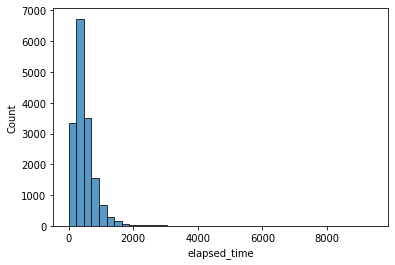

In [ ]:
# Checking the distribution for our target variable elapsed_time
sns.histplot(pandas_df['elapsed_time'],kde=False,bins=40);


From the above graph the distribution is bit left skewed but we are just keeping it as it is to see how it works with the existing model.

In [ ]:
nonFeatureCols = ["elapsed_time", "scaled_elapsed_time"]

In [ ]:
featureCols = [item for item in df.columns if item not in nonFeatureCols]

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features"))

finalPrep = assembler.transform(df)

In [ ]:
training, test = finalPrep.randomSplit([0.7, 0.3])


training.cache()
test.cache()

print(training.count())
print(test.count())

115022
49161


In [ ]:
#Applying Linear Regression model with hyperparameter tuning

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline

lrModel = (LinearRegression()
  .setLabelCol("elapsed_time")
  .setFeaturesCol("features"))

paramGrid = (ParamGridBuilder() \
                 .addGrid(lrModel.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]) \
                 .addGrid(lrModel.regParam, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]) \
                 .build())


stages = [lrModel]

pipeline = Pipeline().setStages(stages)

cv = (CrossValidator() 
  .setEstimator(pipeline)
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("elapsed_time")))

pipelineFitted = cv.fit(training)

In [ ]:
print("The Best Parameters:\n--------------------")
print(pipelineFitted.bestModel.stages[0])
pipelineFitted.bestModel.stages[0].extractParamMap()

The Best Parameters:
--------------------
LinearRegressionModel: uid=LinearRegression_f12c7cfaa316, numFeatures=154


{Param(parent='LinearRegression_f12c7cfaa316', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_f12c7cfaa316', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1,
 Param(parent='LinearRegression_f12c7cfaa316', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_f12c7cfaa316', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_f12c7cfaa316', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_f12c7cfaa316', name='labelCol', doc='label column name.'): 'elapsed_time',
 Param(parent='LinearRegression_f12c7cfaa316', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'squar

In [ ]:
pipelineFitted.bestModel

PipelineModel_a78911686fc6

In [ ]:
holdout1 = pipelineFitted.bestModel.transform(test)


In [ ]:
holdout2 = pipelineFitted.bestModel.transform(training)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="elapsed_time", metricName="r2")

print("Train R2:", evaluator.evaluate(holdout2))
print("Test R2:", evaluator.evaluate(holdout1))

Train R2: 0.6488423655271642
Test R2: 0.6758041869839996


In [ ]:
#Applying Gradient Boost algorithm model

from pyspark.ml.regression import GBTRegressor

# create a GBTRegressor object
gbt = GBTRegressor(featuresCol='features', labelCol='elapsed_time', maxIter=10)
 
# fit the model to the training data
gbt_model = gbt.fit(training)
 
# make predictions on the test data
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select("prediction", "elapsed_time", "features").show()

+------------------+------------+--------------------+
|        prediction|elapsed_time|            features|
+------------------+------------+--------------------+
| 59.07002900437452|           7|(154,[0,2,29,46,5...|
| 87.41454939645496|          34|(154,[0,2,19,43,4...|
|109.95723467983304|          68|(154,[0,2,14,25,4...|
| 80.74133916773056|          79|(154,[0,4,27,42,4...|
|123.42607816744456|         229|(154,[0,4,14,22,4...|
| 161.3540921338035|          63|(154,[0,4,27,46,5...|
|164.27323295083363|         119|(154,[0,5,14,19,4...|
| 168.4597965306314|         131|(154,[0,5,18,41,4...|
|142.46602462465833|         174|(154,[0,4,34,44,4...|
|150.20952825769305|         195|(154,[0,7,14,24,3...|
|  192.615665696746|         202|(154,[0,6,21,40,4...|
|  169.145983363325|         213|(154,[0,5,19,43,4...|
|201.98654591598287|         252|(154,[0,4,23,43,4...|
|263.02258439855734|         131|(154,[0,1,14,27,4...|
|234.77139738048098|         286|(154,[0,11,21,43,...|
|182.41323

In [ ]:
from sklearn.metrics import r2_score
import numpy as np
def plot_regression(df, target, prediction, title):
 
    df['resd']=np.round(df[prediction] - df[target], 4)
    df = df.sort_values(target, ascending=True)
 
    y_test=df[target]
    y_residual=df['resd']
    y_pred = df[prediction]
 
    fig, ax = plt.subplots(figsize=(7,5))
    scatter = ax.scatter(x=y_test, y=y_pred, c=y_residual, cmap="RdYlGn", marker="o", alpha=0.5, label='Predicted')
    cbar = plt.colorbar(scatter)
    cbar.ax.set_ylabel("Residual", rotation=90, fontsize=12)
 
    ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], "g--", alpha=0.75, linewidth=3, label='True')
    ax.set_xlabel("Actual", fontsize=12); 
    ax.set_ylabel("Predicted", fontsize=12); 
    ax.legend(loc='best')
    R_squared = r2_score(y_test, y_pred) 
 
    ax.set_title(title, fontsize=14)
    #additional text at the corner 
    plt.figtext(0.4,0.82,"$R^{2}$ = "+str(np.round(R_squared, 3)), fontsize=12, horizontalalignment="center",backgroundcolor=(0,0,0,0.4),color="w")

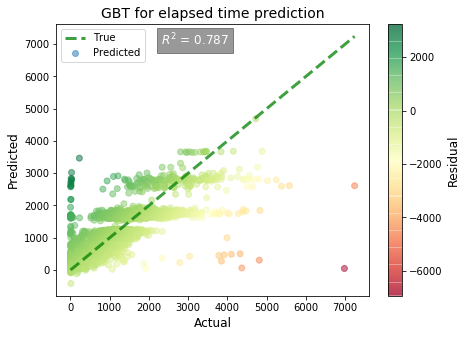

In [ ]:

df_gbt = gbt_predictions.select("elapsed_time","prediction").toPandas()
plot_regression(df_gbt, "elapsed_time", 'prediction', "GBT for elapsed time prediction")

In [ ]:
# Applying Linear Regression model without hypermarameter tuning

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(labelCol='elapsed_time', featuresCol="features")
 
lrModel = lr.fit(training)
lr_prediction = lrModel.transform(test)
lr_prediction.select("prediction", "elapsed_time", "features").show()

+------------------+------------+--------------------+
|        prediction|elapsed_time|            features|
+------------------+------------+--------------------+
|203.83029875569025|           7|(154,[0,2,29,46,5...|
| 379.4955930710126|          34|(154,[0,2,19,43,4...|
|460.49937786448623|          68|(154,[0,2,14,25,4...|
| 255.7890135277695|          79|(154,[0,4,27,42,4...|
|359.27600913250416|         229|(154,[0,4,14,22,4...|
| 203.3146495519502|          63|(154,[0,4,27,46,5...|
|180.59901235306003|         119|(154,[0,5,14,19,4...|
|199.48524283307492|         131|(154,[0,5,18,41,4...|
|147.88074109180843|         174|(154,[0,4,34,44,4...|
| 350.0745525215396|         195|(154,[0,7,14,24,3...|
| 421.6103284701657|         202|(154,[0,6,21,40,4...|
| 290.0574041519172|         213|(154,[0,5,19,43,4...|
|390.35960693158444|         252|(154,[0,4,23,43,4...|
| 374.0169489872623|         131|(154,[0,1,14,27,4...|
|414.44097043167596|         286|(154,[0,11,21,43,...|
|182.06834

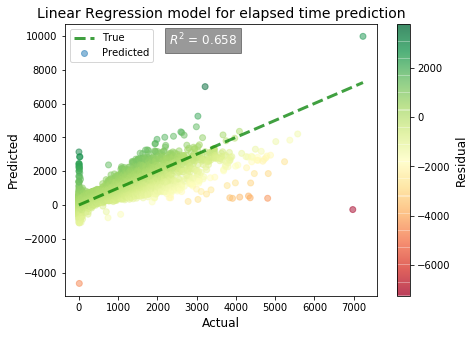

In [ ]:
df_lr = lr_prediction.select("prediction", "elapsed_time").toPandas()
plot_regression(df_lr, "elapsed_time", "prediction", "Linear Regression model for elapsed time prediction")

From the above result we see that Gradient Boost algorithm performed better than Linear Regression model.